## 1. Loading the Model

In [1]:
import json
import torch
import copy
import time
import numpy as np
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset, random_split, DataLoader, Subset
from sklearn.model_selection import train_test_split
from datasets import Dataset

from transformers import AutoTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW

import matplotlib.pyplot as plt

c:\Users\teomi\Projects\FEDDIE\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We initially experimented with RoBERTa-large (355M parameters), but due to resource constraints and slow training times, even with GPU acceleration, it was deemed unsuitable for fine-tuning on our dataset. Instead, we adopted RoBERTa-base (125M parameters), which offers a favorable balance between performance and computational efficiency. This choice aligns with prior literature, particularly Shah, Paturi, and Chava (2023), which found RoBERTa-base to be an effective benchmark for sentiment classification in the context of monetary policy.

The model was fine-tuned using a custom-labeled dataset of sentences classified as Hawkish, Dovish, or Neutral. We used the Hugging Face Transformers library and trained the model using cross-entropy loss with the AdamW optimizer, experimenting with a range of learning rates and weight decay parameters to prevent overfitting. We found the best learning rate and weight decay parameter - a combination that prevents overfitting to the training set while allowing for convergence with low validation loss - to be:
- Learning rate = 1e-7
- Weight decay parameter = 0.01

To monitor generalization performance, we implemented early stopping based on validation loss, which allowed the training to halt once performance plateaued. The best-performing model, achieving a validation loss of 0.583, was saved and is used for inference—predicting the Federal Reserve’s sentiment from a given sentence.

In [2]:
# # Load model directly
# tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-large")
# model = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-large", num_labels=3)

In [3]:
# model.save_pretrained("./saved_roberta_model")
# tokenizer.save_pretrained("./saved_roberta_model")

In [4]:
# tokenizer = AutoTokenizer.from_pretrained("./saved_roberta_model")
# model = RobertaForSequenceClassification.from_pretrained("./saved_roberta_model", torch_dtype=torch.float16, device_map="cuda")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)
model = model.to(torch.float32).to(device)  # ✅ Make sure model uses float32

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
model.save_pretrained("./saved_roberta_base_model")
tokenizer.save_pretrained("./saved_roberta_base_model")

('./saved_roberta_base_model\\tokenizer_config.json',
 './saved_roberta_base_model\\special_tokens_map.json',
 './saved_roberta_base_model\\vocab.json',
 './saved_roberta_base_model\\merges.txt',
 './saved_roberta_base_model\\added_tokens.json',
 './saved_roberta_base_model\\tokenizer.json')

In [4]:
tokenizer = AutoTokenizer.from_pretrained("./saved_roberta_base_model")
model = RobertaForSequenceClassification.from_pretrained("./saved_roberta_base_model", torch_dtype=torch.float32, device_map="cuda")

## 2. Preparing Training Data

In [11]:
# === Load Labeled JSON ===
labeled_data = []

# Load from labeled_sample_sentences.json
with open("../data/labeled_sample_sentences.json", "r", encoding="utf-8") as f:
    labeled_data += json.load(f)

# Load from labeled_cnbc_fed_markets.json
with open("../data/news/labeled_cnbc_fed_markets.json", "r", encoding="utf-8") as f:
    labeled_data += json.load(f)

In [12]:
# === Flatten & Filter Sentences ===
label_map = {"Hawkish": 0, "Dovish": 1, "Neutral": 2}
sentences, labels = [], []

for entry in labeled_data:
    for sentence in entry["labeled_sentences"]:
        label = sentence["label"]
        if label in label_map:
            sentences.append(sentence["sentence"])
            labels.append(label_map[sentence["label"]])

print(f"Total sentences: {len(sentences)}")
print(f"Label distribution: {pd.Series(labels).value_counts().sort_index()}")

# === Convert to Hugging Face Dataset ===
dataset = Dataset.from_dict({
    "sentence": sentences,
    "label": labels
})

Total sentences: 6440
Label distribution: 0    1127
1    1427
2    3886
Name: count, dtype: int64


In [13]:
def tokenize_function(example):
    return tokenizer(
        example["sentence"],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_attention_mask=True
    )

In [14]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 6440/6440 [00:00<00:00, 10914.85 examples/s]


In [15]:
# === Balance Classes BEFORE tensor conversion ===
df_full = tokenized_dataset.to_pandas()

# Check class distribution
print("Original class distribution:")
print(df_full['label'].value_counts().sort_index())

# Sample equal amounts from each class (use minimum class size or a reasonable number)
min_samples = min(df_full['label'].value_counts())
target_samples = min(min_samples, 1127)  # Don't exceed available samples from the smallest class

print(f"Sampling {target_samples} from each class...")

neutral_df = df_full[df_full['label'] == 2].sample(n=target_samples, random_state=42)
hawkish_df = df_full[df_full['label'] == 0].sample(n=target_samples, random_state=42)
dovish_df = df_full[df_full['label'] == 1].sample(n=target_samples, random_state=42)

balanced_df = pd.concat([hawkish_df, dovish_df, neutral_df])
balanced_df = balanced_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Balanced class distribution:")
print(balanced_df['label'].value_counts().sort_index())

Original class distribution:
label
0    1127
1    1427
2    3886
Name: count, dtype: int64
Sampling 1127 from each class...
Balanced class distribution:
label
0    1127
1    1127
2    1127
Name: count, dtype: int64


In [28]:
# === Convert to PyTorch tensors (ONLY ONCE) ===
input_ids = np.array(list(balanced_df["input_ids"]))
attention_mask = np.array(list(balanced_df["attention_mask"]))
labels = np.array(balanced_df["label"])

input_ids_tensor = torch.tensor(input_ids, dtype=torch.long)
attention_mask_tensor = torch.tensor(attention_mask, dtype=torch.long)
labels_tensor = torch.tensor(labels, dtype=torch.long)

print("NaNs in input_ids:", torch.isnan(input_ids_tensor).any().item())
print("NaNs in labels:", torch.isnan(labels_tensor).any().item())

print(f"Final tensor shapes:")
print(f"Input IDs: {input_ids_tensor.shape}")
print(f"Attention Mask: {attention_mask_tensor.shape}")
print(f"Labels: {labels_tensor.shape}")

# === Stratified Split ===
indices = np.arange(len(labels_tensor))
train_indices, val_indices = train_test_split(
    indices, 
    test_size=0.2, 
    stratify=labels,  # Use the correct labels array
    random_state=42
)

print(f"Train size: {len(train_indices)}, Val size: {len(val_indices)}")

NaNs in input_ids: False
NaNs in labels: False
Final tensor shapes:
Input IDs: torch.Size([3381, 128])
Attention Mask: torch.Size([3381, 128])
Labels: torch.Size([3381])
Train size: 2704, Val size: 677


In [18]:
# === Create Datasets and DataLoaders ===
full_dataset = TensorDataset(input_ids_tensor, attention_mask_tensor, labels_tensor)
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# === Verify split is balanced ===
train_labels = labels[train_indices]
val_labels = labels[val_indices]
print("Train set class distribution:", pd.Series(train_labels).value_counts().sort_index())
print("Val set class distribution:", pd.Series(val_labels).value_counts().sort_index())

Train set class distribution: 0    902
1    901
2    901
Name: count, dtype: int64
Val set class distribution: 0    225
1    226
2    226
Name: count, dtype: int64


### Applying class weights instead of downsampling

In [5]:
# === Load Labeled JSON ===
labeled_data = []

# Load from labeled_sample_sentences.json
with open("../data/labeled_sample_sentences.json", "r", encoding="utf-8") as f:
    labeled_data += json.load(f)

# Load from labeled_cnbc_fed_markets.json
with open("../data/news/labeled_cnbc_fed_markets.json", "r", encoding="utf-8") as f:
    labeled_data += json.load(f)

In [6]:
# === Flatten & Filter Sentences ===
label_map = {"Hawkish": 0, "Dovish": 1, "Neutral": 2}
sentences, labels = [], []

for entry in labeled_data:
    for sentence in entry["labeled_sentences"]:
        label = sentence["label"]
        if label in label_map:
            sentences.append(sentence["sentence"])
            labels.append(label_map[sentence["label"]])

print(f"Total sentences: {len(sentences)}")
print(f"Label distribution: {pd.Series(labels).value_counts().sort_index()}")

# === Convert to Hugging Face Dataset ===
dataset = Dataset.from_dict({
    "sentence": sentences,
    "label": labels
})

Total sentences: 6440
Label distribution: 0    1127
1    1427
2    3886
Name: count, dtype: int64


In [7]:
# === Convert to Hugging Face Dataset ===
dataset = Dataset.from_dict({
    "sentence": sentences,
    "label": labels
})

def tokenize_function(example):
    return tokenizer(
        example["sentence"],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_attention_mask=True
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/6440 [00:00<?, ? examples/s]

Map: 100%|██████████| 6440/6440 [00:00<00:00, 13855.84 examples/s]


In [8]:
# === Convert to PyTorch tensors (NO DOWNSAMPLING) ===
df_full = tokenized_dataset.to_pandas()

print("Full dataset class distribution:")
print(df_full['label'].value_counts().sort_index())

input_ids = np.array(list(df_full["input_ids"]))
attention_mask = np.array(list(df_full["attention_mask"]))
labels = np.array(df_full["label"])

input_ids_tensor = torch.tensor(input_ids, dtype=torch.long)
attention_mask_tensor = torch.tensor(attention_mask, dtype=torch.long)
labels_tensor = torch.tensor(labels, dtype=torch.long)

print(f"Final tensor shapes:")
print(f"Input IDs: {input_ids_tensor.shape}")
print(f"Attention Mask: {attention_mask_tensor.shape}")
print(f"Labels: {labels_tensor.shape}")

Full dataset class distribution:
label
0    1127
1    1427
2    3886
Name: count, dtype: int64
Final tensor shapes:
Input IDs: torch.Size([6440, 128])
Attention Mask: torch.Size([6440, 128])
Labels: torch.Size([6440])


In [9]:
# === Stratified Split ===
indices = np.arange(len(labels_tensor))
train_indices, val_indices = train_test_split(
    indices, 
    test_size=0.2, 
    stratify=labels,  # Maintains class proportions in train/val
    random_state=42
)

print(f"Train size: {len(train_indices)}, Val size: {len(val_indices)}")

Train size: 5152, Val size: 1288


In [10]:
# === Create Datasets and DataLoaders ===
full_dataset = TensorDataset(input_ids_tensor, attention_mask_tensor, labels_tensor)
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# === Verify split maintains class proportions ===
train_labels = labels[train_indices]
val_labels = labels[val_indices]
print("Train set class distribution:", pd.Series(train_labels).value_counts().sort_index())
print("Val set class distribution:", pd.Series(val_labels).value_counts().sort_index())

Train set class distribution: 0     901
1    1142
2    3109
Name: count, dtype: int64
Val set class distribution: 0    226
1    285
2    777
Name: count, dtype: int64


## 3. Training the Model

In [11]:
# set up the optimizer that adapts learning rates for different parameters 
# [RECALL: w* = w - lambda * (w)^2]
# optimizer = AdamW(model.parameters(), lr=1e-7, weight_decay=0.01)
optimizer = AdamW(model.parameters(), lr=5e-7, weight_decay=0.01)

# put the model on device
device = torch.device('cuda')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

Epoch 1 | Train Loss: 1.0572 | Val Loss: 1.0487 | Duration: 2.57 min
Epoch 2 | Train Loss: 1.0355 | Val Loss: 1.0269 | Duration: 2.59 min
Epoch 3 | Train Loss: 1.0099 | Val Loss: 0.9893 | Duration: 2.65 min
Epoch 4 | Train Loss: 0.9588 | Val Loss: 0.9091 | Duration: 2.80 min
Epoch 5 | Train Loss: 0.8960 | Val Loss: 0.8643 | Duration: 6.70 min
Epoch 6 | Train Loss: 0.8677 | Val Loss: 0.8464 | Duration: 2.59 min
Epoch 7 | Train Loss: 0.8612 | Val Loss: 0.8337 | Duration: 2.79 min
Epoch 8 | Train Loss: 0.8472 | Val Loss: 0.8240 | Duration: 7.14 min
Epoch 9 | Train Loss: 0.8374 | Val Loss: 0.8153 | Duration: 8.61 min
Epoch 10 | Train Loss: 0.8301 | Val Loss: 0.8077 | Duration: 2.58 min
Epoch 11 | Train Loss: 0.8201 | Val Loss: 0.8010 | Duration: 2.64 min
Epoch 12 | Train Loss: 0.8158 | Val Loss: 0.7948 | Duration: 2.73 min
Epoch 13 | Train Loss: 0.8050 | Val Loss: 0.7890 | Duration: 2.79 min
Epoch 14 | Train Loss: 0.7942 | Val Loss: 0.7839 | Duration: 2.77 min
Epoch 15 | Train Loss: 0.7908

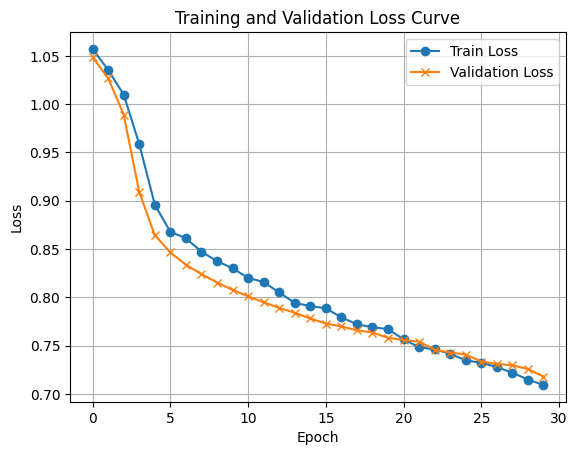

In [ ]:
# # === Early Stopping Configuration ===
# patience = 3
# best_val_loss = float('inf')
# epochs_without_improvement = 0
# best_model_state = None

# # === Track losses ===
# train_losses = []
# val_losses = []

# # === Training loop ===
# epochs = 30  # Set higher value since early stopping is used
# for epoch in range(epochs):
#     start_time = time.time()

#     # === TRAINING ===
#     model.train()
#     total_train_loss = 0

#     for batch in train_loader:
#         b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]
#         model.zero_grad()

#         outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
#         loss = outputs.loss

#         # Safely detach loss for logging
#         loss_val = loss.detach().item()
#         total_train_loss += loss_val

#         loss.backward()
#         # Clip gradients to prevent exploding gradients
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()

#     avg_train_loss = total_train_loss / len(train_loader)
#     train_losses.append(avg_train_loss)

#     # === VALIDATION ===
#     model.eval()
#     total_val_loss = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]
#             outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
#             val_loss = outputs.loss
#             total_val_loss += val_loss.item()

#     avg_val_loss = total_val_loss / len(val_loader)
#     val_losses.append(avg_val_loss)

#     end_time = time.time()
#     epoch_duration = (end_time - start_time) / 60

#     print(f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Duration: {epoch_duration:.2f} min")

#     # === Early Stopping Check ===
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         best_model_state = copy.deepcopy(model.state_dict())
#         epochs_without_improvement = 0
#     else:
#         epochs_without_improvement += 1
#         if epochs_without_improvement >= patience:
#             print(f"Early stopping triggered at epoch {epoch + 1}")
#             break

# # === Load Best Model ===
# if best_model_state is not None:
#     model.load_state_dict(best_model_state)
#     print(f"Best model loaded with val loss: {best_val_loss:.4f}")

# # === Save Best Model ===
# model.save_pretrained("./finetuned_roberta_model_2")
# tokenizer.save_pretrained("./finetuned_roberta_model_2")

# # === Plot Loss Curve ===
# plt.plot(train_losses, label='Train Loss', marker='o')
# plt.plot(val_losses, label='Validation Loss', marker='x')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.title("Training and Validation Loss Curve")
# plt.grid(True)
# plt.show()

Epoch 1 | Train Loss: 1.0198 | Val Loss: 0.8718 | Duration: 2.58 min
Epoch 2 | Train Loss: 0.8485 | Val Loss: 0.8021 | Duration: 2.59 min
Epoch 3 | Train Loss: 0.8111 | Val Loss: 0.7737 | Duration: 2.59 min
Epoch 4 | Train Loss: 0.7779 | Val Loss: 0.7684 | Duration: 2.60 min
Epoch 5 | Train Loss: 0.7540 | Val Loss: 0.7350 | Duration: 2.70 min
Epoch 6 | Train Loss: 0.7301 | Val Loss: 0.7268 | Duration: 2.74 min
Epoch 7 | Train Loss: 0.7070 | Val Loss: 0.7007 | Duration: 2.80 min
Epoch 8 | Train Loss: 0.6805 | Val Loss: 0.6728 | Duration: 2.82 min
Epoch 9 | Train Loss: 0.6557 | Val Loss: 0.6518 | Duration: 2.89 min
Epoch 10 | Train Loss: 0.6240 | Val Loss: 0.6275 | Duration: 3.10 min
Epoch 11 | Train Loss: 0.5931 | Val Loss: 0.6013 | Duration: 3.15 min
Epoch 12 | Train Loss: 0.5653 | Val Loss: 0.5836 | Duration: 3.18 min
Epoch 13 | Train Loss: 0.5393 | Val Loss: 0.5624 | Duration: 3.27 min
Epoch 14 | Train Loss: 0.5144 | Val Loss: 0.5517 | Duration: 3.26 min
Epoch 15 | Train Loss: 0.4841

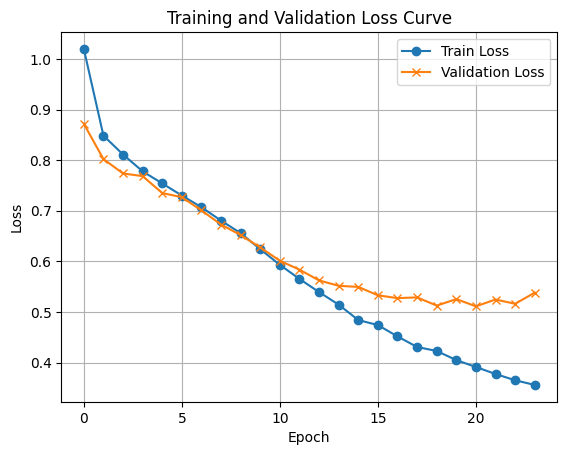

: 

In [ ]:
# # === Early Stopping Configuration ===
# patience = 3
# best_val_loss = float('inf')
# epochs_without_improvement = 0
# best_model_state = None

# # === Track losses ===
# train_losses = []
# val_losses = []

# # === Training loop ===
# epochs = 30  # Set higher value since early stopping is used
# for epoch in range(epochs):
#     start_time = time.time()

#     # === TRAINING ===
#     model.train()
#     total_train_loss = 0

#     for batch in train_loader:
#         b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]
#         model.zero_grad()

#         outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
#         loss = outputs.loss

#         # Safely detach loss for logging
#         loss_val = loss.detach().item()
#         total_train_loss += loss_val

#         loss.backward()
#         # Clip gradients to prevent exploding gradients
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()

#     avg_train_loss = total_train_loss / len(train_loader)
#     train_losses.append(avg_train_loss)

#     # === VALIDATION ===
#     model.eval()
#     total_val_loss = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]
#             outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
#             val_loss = outputs.loss
#             total_val_loss += val_loss.item()

#     avg_val_loss = total_val_loss / len(val_loader)
#     val_losses.append(avg_val_loss)

#     end_time = time.time()
#     epoch_duration = (end_time - start_time) / 60

#     print(f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Duration: {epoch_duration:.2f} min")

#     # === Early Stopping Check ===
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         best_model_state = copy.deepcopy(model.state_dict())
#         epochs_without_improvement = 0
#     else:
#         epochs_without_improvement += 1
#         if epochs_without_improvement >= patience:
#             print(f"Early stopping triggered at epoch {epoch + 1}")
#             break

# # === Load Best Model ===
# if best_model_state is not None:
#     model.load_state_dict(best_model_state)
#     print(f"Best model loaded with val loss: {best_val_loss:.4f}")

# # === Save Best Model ===
# model.save_pretrained("./finetuned_roberta_model_3")
# tokenizer.save_pretrained("./finetuned_roberta_model_3")

# # === Plot Loss Curve ===
# plt.plot(train_losses, label='Train Loss', marker='o')
# plt.plot(val_losses, label='Validation Loss', marker='x')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.title("Training and Validation Loss Curve")
# plt.grid(True)
# plt.show()

In [ ]:
# === Early Stopping Configuration ===
patience = 3
overfit_epochs = 0
best_val_loss = float('inf')
best_model_state = None

# === Track losses ===
train_losses = []
val_losses = []

# === Training loop ===
epochs = 30  # Set higher value since early stopping is used
for epoch in range(epochs):
    start_time = time.time()

    # === TRAINING ===
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]
        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss

        # Safely detach loss for logging
        loss_val = loss.detach().item()
        total_train_loss += loss_val

        loss.backward()
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # === VALIDATION ===
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]
            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    end_time = time.time()
    epoch_duration = (end_time - start_time) / 60

    print(f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Duration: {epoch_duration:.2f} min")

    # Early stopping: Stop if val loss > train loss for 3 epochs
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        overfit_epochs = 0  # Reset counter if val loss improves
    else:
        if avg_val_loss > avg_train_loss:
            overfit_epochs += 1
            print(f"🔁 Epoch {epoch+1}: Overfitting counter = {overfit_epochs} (val_loss > train_loss)")
        else:
            overfit_epochs = 0  # Reset if no overfitting this epoch

        if overfit_epochs >= patience:
            print(f"Early stopping triggered due to overfitting at epoch {epoch + 1}")
            break

# === Load Best Model ===
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Best model loaded with val loss: {best_val_loss:.4f}")

# === Save Best Model ===
model.save_pretrained("../models/finetuned_roberta_model_4")
tokenizer.save_pretrained("../models/finetuned_roberta_model_4")

# === Plot Loss Curve ===
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Curve")
plt.grid(True)
plt.show()